In [13]:
using JLD2
using Plots
using Statistics



In [14]:
file_00 = joinpath(@__DIR__, "full_ent_spec_data_0.0.jld2")
file_002 = joinpath(@__DIR__, "full_ent_spec_data_0.002.jld2")

data_002 = JLD2.load(file_002)
results_002 = data_002["entanglement_spectrum_results"]

data_00 = JLD2.load(file_00)
results_00 = data_00["entanglement_spectrum_results"]

Dict{Int64, Vector{Float64}} with 8 entries:
  70 => [0.428404, 0.428404, 0.383309, 0.383309, 0.306647, 0.306647, 0.219033, …
  50 => [0.462527, 0.462527, 0.396451, 0.396451, 0.290731, 0.290731, 0.181707, …
  20 => [0.586275, 0.488562, 0.488562, 0.279179, 0.279179, 0.104692, 0.104692, …
  60 => [0.451059, 0.422868, 0.422868, 0.348244, 0.348244, 0.25151, 0.25151, 0.…
  90 => [0.404013, 0.404013, 0.370345, 0.370345, 0.31109, 0.31109, 0.2393, 0.23…
  30 => [0.516676, 0.516676, 0.401859, 0.401859, 0.241115, 0.241115, 0.109598, …
  80 => [0.420414, 0.400394, 0.400394, 0.345795, 0.345795, 0.270622, 0.270622, …
  40 => [0.497623, 0.452385, 0.452385, 0.339289, 0.339289, 0.208793, 0.208793, …

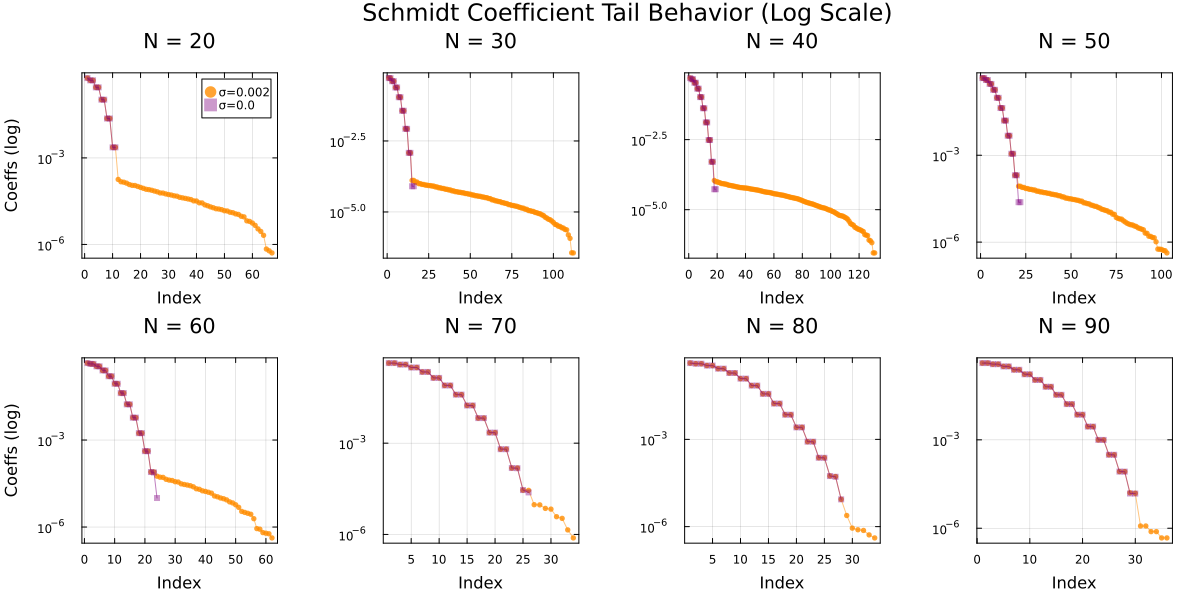

In [15]:

# ==============================================================================
# 1. Replicate "Tail Behavior" Plot (Comparing Two Datasets)
# ==============================================================================
"""
Replicates the functionality of 'full_ent_spec_plot_tail.jl'.
It loads two JLD2 data files (e.g., sigma=0.0 and sigma=0.002) and plots
the Schmidt coefficient tails for N=20..90 on a 2x4 grid.

Returns the plot object.
"""
function plot_tail_comparison(file_path_1::String, file_path_2::String; 
                              save_plot::Bool=false, output_file::String="tail_plot.png")
    
    if !isfile(file_path_1) || !isfile(file_path_2)
        error("One or both data files not found: \n $file_path_1 \n $file_path_2")
    end

    # [cite_start]Load Data [cite: 17, 18]
    d1 = JLD2.load(file_path_1)
    d2 = JLD2.load(file_path_2)

    r1 = d1["entanglement_spectrum_results"]
    r2 = d2["entanglement_spectrum_results"]
    
    # Extract Metadata
    N_vals = d1["N_values"]
    sigma_1 = d1["σ_val"]
    sigma_2 = d2["σ_val"]

    # [cite_start]Plot Settings [cite: 19]
    # Adjusted slightly for notebook viewing, but keeping high res
    p = plot(
        layout = (2, 4),
        size = (1200, 600), # Scaled down slightly from original 2400x1000 for notebook fitting
        plot_title = "Schmidt Coefficient Tail Behavior (Log Scale)",
        plot_titlefontsize = 16,
        legend = :topright,
        margin = 5Plots.mm
    )

    for (i, N) in enumerate(N_vals)
        title_str = "N = $N"
        
        # [cite_start]Get and Sort Coefficients [cite: 19, 20]
        v1 = haskey(r1, N) ? sort(r1[N], rev=true) : nothing
        v2 = haskey(r2, N) ? sort(r2[N], rev=true) : nothing

        # [cite_start]Labels only on the first subplot [cite: 21, 22]
        l1 = (i == 1) ? "σ=$sigma_1" : ""
        l2 = (i == 1) ? "σ=$sigma_2" : ""

        # [cite_start]Plot Second Dataset (e.g., sigma=0.002) - Orange [cite: 23]
        if v2 !== nothing
            mask = v2 .> 0
            y = v2[mask]
            x = (1:length(v2))[mask]
            
            plot!(p, subplot=i, x, y, 
                seriestype=:scatter, markershape=:circle, markersize=3, 
                markerstrokewidth=0, color=:darkorange, alpha=0.8, label=l2)
            plot!(p, subplot=i, x, y, 
                seriestype=:path, color=:darkorange, alpha=0.5, label="")
        end

        # [cite_start]Plot First Dataset (e.g., sigma=0.0) - Purple [cite: 24, 25]
        if v1 !== nothing
            mask = v1 .> 0
            y = v1[mask]
            x = (1:length(v1))[mask]
            
            plot!(p, subplot=i, x, y, 
                seriestype=:scatter, markershape=:rect, markersize=3, 
                markerstrokewidth=0, color=:purple, alpha=0.4, label=l1)
            plot!(p, subplot=i, x, y, 
                seriestype=:path, color=:purple, alpha=0.5, label="")
        end

        # [cite_start]Formatting [cite: 26]
        plot!(p, subplot=i,
            title = title_str,
            xlabel = "Index",
            ylabel = (i % 4 == 1 ? "Coeffs (log)" : ""), # Only label y-axis on left plots
            yaxis = :log10,
            framestyle = :box
        )
    end

    if save_plot
        savefig(p, output_file)
        println("Comparison plot saved to $output_file")
    end

    return p
end


p1 = plot_tail_comparison(file_00, file_002)
display(p1)


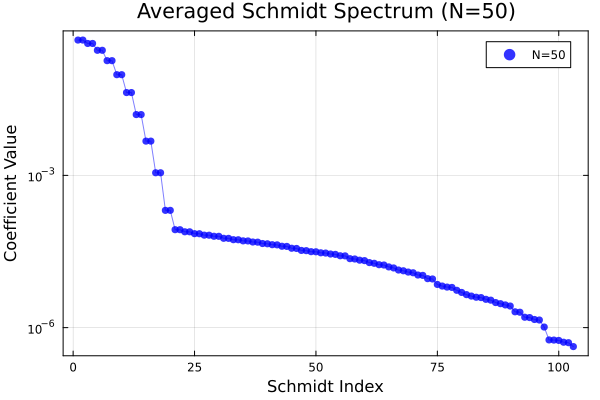

In [16]:

# ==============================================================================
# 2. Plot Averaged Schmidt Spectrum for a Single N
# ==============================================================================
"""
Plots the averaged Schmidt spectrum vs index for a specific N from a results dictionary.
"""
function plot_single_N_spectrum(results_dict::Dict, N::Int; color=:blue)
    if !haskey(results_dict, N)
        error("N=$N not found in results dictionary.")
    end

    coeffs = sort(results_dict[N], rev=true)
    
    # Filter strictly positive for log plot
    mask = coeffs .> 0
    y = coeffs[mask]
    x = (1:length(coeffs))[mask]

    p = plot(x, y,
        seriestype = :scatter,
        markershape = :circle,
        markersize = 4,
        markerstrokewidth = 0,
        color = color,
        alpha = 0.8,
        label = "N=$N",
        yaxis = :log10,
        title = "Averaged Schmidt Spectrum (N=$N)",
        xlabel = "Schmidt Index",
        ylabel = "Coefficient Value",
        framestyle = :box,
        grid = true
    )
    # Add connecting line
    plot!(p, x, y, seriestype=:path, color=color, alpha=0.5, label="")
    
    return p
end



p2 = plot_single_N_spectrum(results_002, 50)
display(p2)


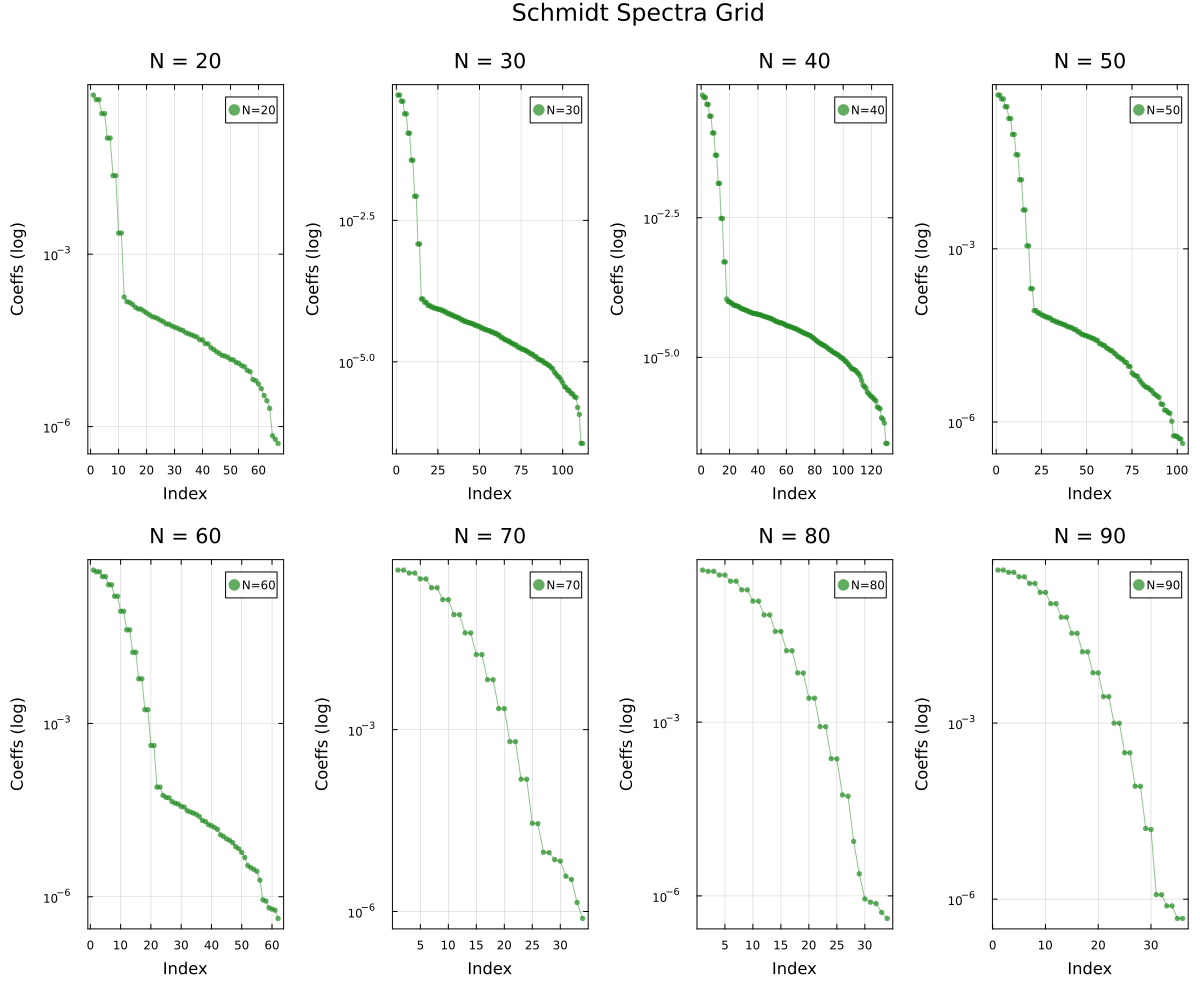

In [17]:

# ==============================================================================
# 3. Plot Averaged Spectrum for Multiple N on a Grid (4x2)
# ==============================================================================
"""
Plots the Schmidt spectrum for N = 20, 30, ..., 90 on a 4x2 grid layout.
Takes a single results dictionary (e.g., for one specific sigma).
"""
function plot_multi_N_grid(results_dict::Dict; 
                           N_values=[20, 30, 40, 50, 60, 70, 80, 90],
                           color=:forestgreen)
    
    # Define Layout: 4 rows, 2 columns
    p = plot(
        layout = (2, 4),
        size = (1200, 1000),
        plot_title = "Schmidt Spectra Grid",
        plot_titlefontsize = 16,
        left_margin = 5Plots.mm,
        bottom_margin = 5Plots.mm
    )

    for (i, N) in enumerate(N_values)
        if !haskey(results_dict, N)
            println("Warning: N=$N not found in data, skipping subplot $i")
            continue
        end

        coeffs = sort(results_dict[N], rev=true)
        mask = coeffs .> 0
        y = coeffs[mask]
        x = (1:length(coeffs))[mask]

        # Plot Scatter
        plot!(p, subplot=i, x, y, 
            seriestype=:scatter, markershape=:circle, markersize=3, 
            markerstrokewidth=0, color=color, alpha=0.7, label="N=$N")
        
        # Plot Line
        plot!(p, subplot=i, x, y, 
            seriestype=:path, color=color, alpha=0.5, label="")

        # Formatting
        plot!(p, subplot=i,
            title = "N = $N",
            yaxis = :log10,
            xlabel = "Index",
            ylabel = "Coeffs (log)",
            framestyle = :box
        )
    end

    return p
end


p3 = plot_multi_N_grid(results_002)
display(p3)



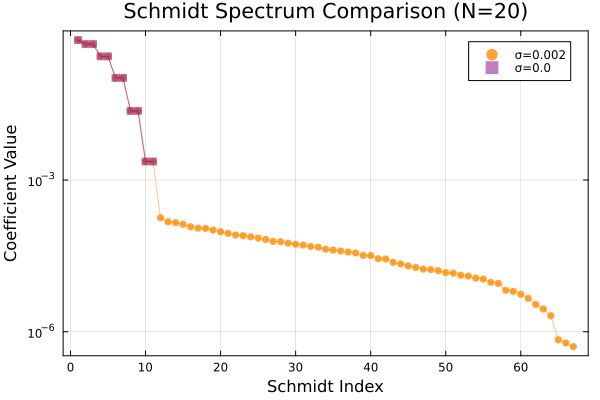

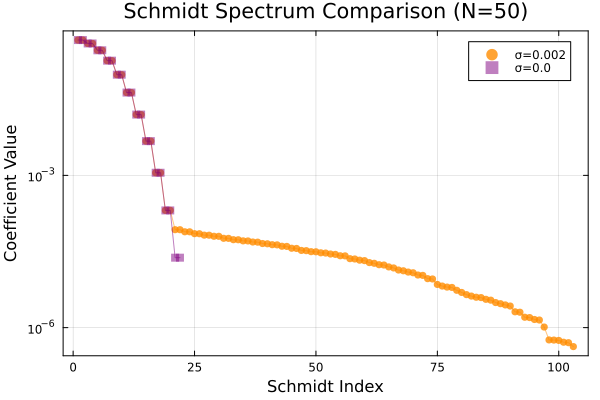

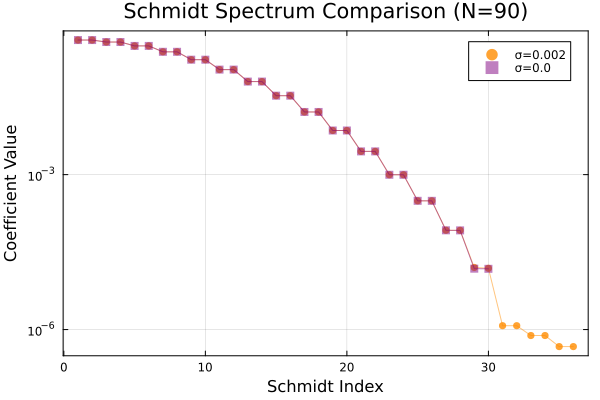

In [23]:
# ==============================================================================
# 4. Single N Comparison: Plots both spectra on one plot
# ==============================================================================
"""
Plots the averaged Schmidt spectrum for a specific N, overlaying data from 
two different result dictionaries (e.g. sigma=0.0 and sigma=0.002).
"""
function plot_single_N_comparison(results_1::Dict, results_2::Dict, N::Int; 
                                  label1="σ=0.0", label2="σ=0.002")
    
    # Check if N exists in at least one dictionary
    if !haskey(results_1, N) && !haskey(results_2, N)
        error("N=$N found in neither results dictionary.")
    end

    p = plot(
        title = "Schmidt Spectrum Comparison (N=$N)",
        xlabel = "Schmidt Index",
        ylabel = "Coefficient Value",
        yaxis = :log10,
        framestyle = :box,
        grid = true,
        legend = :topright
    )
    
    # --- Plot Dataset 2 (e.g. sigma=0.002) ---
    if haskey(results_2, N)
        v2 = sort(results_2[N], rev=true)
        mask2 = v2 .> 0
        y2 = v2[mask2]
        x2 = (1:length(v2))[mask2]

        plot!(p, x2, y2, 
            seriestype=:scatter, markershape=:circle, markersize=4, 
            markerstrokewidth=0, color=:darkorange, alpha=0.8, label=label2)
        plot!(p, x2, y2, seriestype=:path, color=:darkorange, alpha=0.5, label="")
    end
    # --- Plot Dataset 1 (e.g. sigma=0.0) ---
    if haskey(results_1, N)
        v1 = sort(results_1[N], rev=true)
        mask1 = v1 .> 0
        y1 = v1[mask1]
        x1 = (1:length(v1))[mask1]

        plot!(p, x1, y1, 
            seriestype=:scatter, markershape=:rect, markersize=4, 
            markerstrokewidth=0, color=:purple, alpha=0.5, label=label1)
        plot!(p, x1, y1, seriestype=:path, color=:purple, alpha=0.5, label="")
    end

    
    return p
end


p_single = plot_single_N_comparison(results_00, results_002, 20)
display(p_single)

p_single = plot_single_N_comparison(results_00, results_002, 50)
display(p_single)

p_single = plot_single_N_comparison(results_00, results_002, 90)
display(p_single)